<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/FundusPhoto_sample_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
os.chdir(path)

FILENAME_LABELCSV = 'age_train.csv' #年齢の値のcsv
FILENAME_RESULTCSV = 'result.csv' #年齢推定結果を書き出すcsv
imagesize_process = (128,128)  #処理時の画像サイズ→小さすぎるような気がする？

In [6]:
# ディレクトリ内の画像を読み込む
# inputpath: ディレクトリのパス, imagesize: 画像サイズ, type_color: ColorかGray


def load_images(inputpath, imagesize, type_color):
    imglist = []
    filenamelist = []

    for root, dirs, files in os.walk(inputpath):
        t=1
        for fn in sorted(files):
            bn, ext = os.path.splitext(fn)
            if ext not in [".bmp", ".BMP", ".jpg", ".JPG", ".jpeg", ".JPEG", ".png", ".PNG"]:
                continue
            # if 'R.jpg' not in fn:
            #     continue

            filename = os.path.join(root, fn)
            
            if type_color == 'Color':
                # カラー画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_COLOR)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, imagesize, interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                testimage = np.asarray(testimage, dtype=np.float32)
                # 色チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)
                # チャンネルをbgrからrgbの順に変更
                #testimage = testimage[:,:,::-1]

                #cv2_imshow(testimage)
                print(str(t))
                t+=1

            
            elif type_color == 'Gray':
                # グレースケール画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, imagesize, interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                # チャンネルの次元がないので1次元追加する
                testimage = np.asarray(testimage, dtype=np.float32).reshape((imagesize[1], imagesize[0], 1))
                # チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)

            imglist.append(testimage)
            filenamelist.append(fn)
    imgsdata = np.asarray(imglist, dtype=np.float32)

    return imgsdata, filenamelist  # 画像リストとファイル名のリストを返す



#読み込んだ画像ファイル名リストに対して正解年齢リストを作成して返す
#読み込んだ画像ファイル名リスト，csvのファイル名リスト，csvの年齢リストを受け取り，ファイル名が一致したら年齢を割り当てる
def get_label(image_filenames, label_filename, label_age):
    labels = []
    for i in range(len(image_filenames)):
        labelfound = False
        for j in range(len(label_filename)):
            if image_filenames[i] == label_filename[j]:
                labels.append(label_age[j])
                labelfound = True
                break
        
        #csv中に画像に該当するageがなかった
        if labelfound == False:
            labels.append(-1)    #目印としてラベルを-1にする
            print('Age data is not found for %s'%(image_filenames[i]))
            
    return labels

In [14]:
#csvファイルを開く
df_labelcsv = pd.read_csv(FILENAME_LABELCSV)

#csvファイルを表示
print(df_labelcsv)

#ID,ageの列の値をリストとして取り出す
labelcsv_filename = df_labelcsv['filename'].values
labelcsv_age = df_labelcsv['age'].values

#データ準備
#画像読み込み
image_org, image_org_filenames = load_images('./img_train/', (192,128), 'Color')
print("images loaded...")

#画像clippingし左右の黒帯部分を除く
image_org_clip = image_org[:, :, 32:160, ...]

                   filename  age
0     img00085008_00_1R.jpg   61
1     img00085024_00_1R.jpg   29
2     img00241280_10_1R.jpg   51
3     img00265140_00_1R.jpg   29
4     img00265140_00_2L.jpg   29
...                     ...  ...
1409  img76791392_10_1R.jpg   38
1410  img76843122_10_1R.jpg   49
1411  img76843122_11_1R.jpg   49
1412  img76888512_00_1R.jpg   74
1413  img76888512_00_2L.jpg   74

[1414 rows x 2 columns]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172

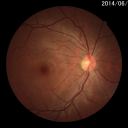

1013


In [15]:
#処理後の画像を表示
cv2_imshow(image_org_clip[0])

#処理後イメージの総数
print(len(image_org_clip))

In [16]:
#画像それぞれについて，画像ファイル名の中にcsvのIDの値が含まれていたらageをラベルとして取り出す
label_org = get_label(image_org_filenames, labelcsv_filename, labelcsv_age)

#ラベルが-1(csvに年齢がなかった)のラベルと画像を削除する
label_org = np.asarray(label_org, dtype=np.float32)
label_mask = np.where(label_org >= 0, True, False)
image = image_org_clip[label_mask]
image_filenames = np.array(image_org_filenames)[label_mask]
label = label_org[label_mask]

if len(image) != len(label):
    print('Numbers of train images and labels not match. Something wrong.')

#ラベル不一致を除外した後のイメージ総数
print(len(image))

1013


In [17]:
#trainデータをtrainとtestデータに分割（8:2）
image_train, image_test, label_train, label_test = train_test_split(image, label, test_size=0.2)

print('Data load finished')
print('Data numbers for train: ' + repr(len(image_train)) + ', test: ' + repr(len(image_test)))



NameError: ignored

In [7]:
#trainデータをtrainとtestデータに分割（8:2）
image_train, image_test, label_train, label_test = train_test_split(image, label, test_size=0.2)

print('Data load finished')
print('Data numbers for train: ' + repr(len(image_train)) + ', test: ' + repr(len(image_test)))


#値の正規化
image_train /= 255.0
image_test /= 255.0

label_train /= 100.0 #年齢は100で割る
label_test /= 100.0


#%%
#年齢推定モデル
def model_cnn1():
    input_img = Input(shape=(imagesize_process[1], imagesize_process[0], 3))
    
    x = Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    
    x = Flatten()(x)
    
    x = Dense(64, activation='linear')(x)
    x = Dropout(0.1)(x)
    x = Dense(8, activation='linear')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    return model


model = model_cnn1()

#モデル構造表示
#print(model.summary())


#学習の設定
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.00001)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

#学習
training = model.fit(image_train, label_train,
                    epochs=50, batch_size=6, shuffle=True, validation_data=(image_test, label_test), verbose=1)


#学習済みモデルをファイルに保存
#モデル
json_string = model.to_json()
open('model.json', 'w').write(json_string)
#重み
model.save_weights('weight.hdf5')


#学習履歴表示
def plot_history(history):
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('mean absolute error')
    plt.xlabel('epoch')
    plt.ylabel('mae')
    plt.yscale('log')
    plt.legend(['mae', 'val_mae'], loc='lower right')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()
    
plot_history(training)


#testデータを用いた推定
result = model.predict(image_test, verbose=1)

#値の範囲を元に戻す
label_test = label_test*100.0
result = result*100.0

result_mse = mean_squared_error(label_test, result)
print('MSE : %.2f'%(result_mse ** 0.5))


#推定結果をcsvファイルに書き出し
f = open(FILENAME_RESULTCSV, 'w')
writer = csv.writer(f, lineterminator='\n')

savedata = ['true_age', 'estimate_age']
writer.writerow(savedata)

for i in range(len(label_test)):
    savedata = [label_test[i], result[i][0]]
    writer.writerow(savedata)

f.close()

KeyboardInterrupt: ignored